# Seleção de Modelos de Regressão com Validação Cruzada

**Objetivo deste notebook:**
 - Carregar a base de dados pré-processada
 - Separar em treino e teste
 - Definir diferentes modelos de regressão com fundamentos distintos
 - Usar validação cruzada e busca em grade para selecionar o melhor modelo e hiperparâmetros
 - Treinar a melhor hipótese encontrada em todos os dados de treino
 - Avaliar o desempenho final no conjunto de teste utilizando métricas de erro

# Escolha dos modelos:
A estratégia adotada busca comparar três famílias de algoritmos para entender qual se adapta melhor à complexidade dos dados de frete:

1. **Modelo Linear (`LinearRegression`):**
   - Serve como baseline. Assume uma relação linear simples.

2. **Modelo de Ensemble - Bagging (`RandomForestRegressor`):**
   - Baseado em comitê de árvores independentes treinadas em paralelo.

3. **Modelo de Ensemble - Boosting (`LGBMRegressor`):**
   - Baseado em árvores sequenciais, onde cada nova árvore tenta corrigir os erros da anterior.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np

from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

C:\ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = Path("../../../")
DATA_PROCESSED = BASE_PATH / "data" / "processed" / "T3" / "regressao"
MODEL_PATH = BASE_PATH / "models" / "T3" / "regressao"

In [3]:
df = pd.read_csv(DATA_PROCESSED / "freight_prediction_abt.csv")

## Seleção de Features e Target

In [4]:
num_cols = [
    'price',
    'final_weight_g',
    'volume_cm3',
    'product_density',
    'lat_customer',
    'lng_customer',
    'lat_seller',
    'lng_seller',
    'distance_km',
    'same_state'
]

cat_cols = [
    'customer_state',
    'seller_state',
]

target = 'freight_value'

X = df[num_cols + cat_cols]
y = df[target]

X.head()

,price,final_weight_g,volume_cm3,product_density,lat_customer,lng_customer,lat_seller,lng_seller,distance_km,same_state,customer_state,seller_state
0,58.90,650.0,3528.0,0.184240,-21.762775,-41.309633,-22.496953,-44.127492,301.504681,0,RJ,SP
1,239.90,30000.0,60000.0,0.500000,-20.220527,-50.903424,-23.565096,-46.518565,585.563937,1,SP,SP
2,199.00,3050.0,14157.0,0.215441,-19.870305,-44.593326,-22.262584,-46.171124,312.343511,1,MG,MG
3,12.99,400.0,2400.0,0.083333,-23.089925,-46.611654,-20.553624,-47.387359,293.168420,1,SP,SP
4,199.90,7000.0,42000.0,0.089286,-23.243402,-46.827614,-22.929384,-53.135873,646.163463,0,SP,PR


## Separação Treino / Teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
)

print("Tamanho treino:", X_train.shape[0])
print("Tamanho teste:", X_test.shape[0])

Tamanho treino: 98670
Tamanho teste: 10964


## Definição dos modelos e grades de hiperparâmetros

In [6]:
# Escala dados e vetoriza categorias.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Dicionário de pipelines
pipelines = {
    "linear_regression": Pipeline([
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]),
    "random_forest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
    "lightgbm": Pipeline([
        ("preprocessor", preprocessor),
        ("model", LGBMRegressor(
            random_state=42
        ))
    ])
}

# Grades de hiperparâmetros relativas a cada pipeline
param_grids = {
    "linear_regression": {},
    "random_forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [10, 20],
        "model__min_samples_leaf": [5, 10]
    },
    "lightgbm": {
        "model__n_estimators": [200, 400],
        "model__learning_rate": [0.05, 0.1],
        "model__num_leaves": [31, 50]
    }
}

## Validação cruzada com GridSearchCV

In [7]:
results = []

for name, pipe in pipelines.items():
    print(f"Treinando e validando modelo: {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    results.append({
        "modelo": name,
        "melhor_score_cv": grid.best_score_,
        "melhores_params": grid.best_params_,
        "best_estimator": grid.best_estimator_
    })

# Colocar resultados em DataFrame para visualizar
results_df = pd.DataFrame([
    {
        "modelo": r["modelo"],
        "rmse_medio_cv": -r["melhor_score_cv"],
        "melhores_params": r["melhores_params"]
    }
    for r in results
]).sort_values(by="rmse_medio_cv", ascending=True)

results_df

Treinando e validando modelo: linear_regression
Treinando e validando modelo: random_forest
Treinando e validando modelo: lightgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 98670, number of used features: 54
[LightGBM] [Info] Start training from score 19.942476


,modelo,rmse_medio_cv,melhores_params
2,lightgbm,7.521810,"{'model__learning_rate': 0.1, 'model__n_estima..."
1,random_forest,7.696705,"{'model__max_depth': 20, 'model__min_samples_l..."
0,linear_regression,10.098240,{}


## Escolher o melhor modelo segundo a validação cruzada

In [8]:
# Encontrar o melhor resultado
best_result = max(results, key=lambda r: r["melhor_score_cv"])

df_campeao = pd.DataFrame({
    "Item": ["Modelo Campeão", "Melhor Score (RMSE CV)", "Melhores Parâmetros"],
    "Resultado": [
        best_result["modelo"],
        f"R$ {-best_result['melhor_score_cv']:.4f}",
        str(best_result["melhores_params"])
    ]
})

with pd.option_context('display.max_colwidth', None):
    display(df_campeao)

,Item,Resultado
0,Modelo Campeão,lightgbm
1,Melhor Score (RMSE CV),R$ 7.5218
2,Melhores Parâmetros,"{'model__learning_rate': 0.1, 'model__n_estimators': 400, 'model__num_leaves': 50}"


## Avaliar o melhor modelo no conjunto de teste

In [9]:
best_model = best_result["best_estimator"]

# Reajustar no conjunto de treino completo
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rmse_test = root_mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

df_resultado = pd.DataFrame({
    "Métrica": ["RMSE (Erro Médio)", "MAE (Erro Absoluto)", "R² (Explicação)"],
    "Valor": [f"R$ {rmse_test:.2f}", f"R$ {mae_test:.2f}", f"{r2_test:.2%}"]
})

display(df_resultado)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 98670, number of used features: 54
[LightGBM] [Info] Start training from score 19.942476


C:\ds\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Métrica,Valor
0,RMSE (Erro Médio),R$ 7.49
1,MAE (Erro Absoluto),R$ 3.41
2,R² (Explicação),76.90%


## Análises extras

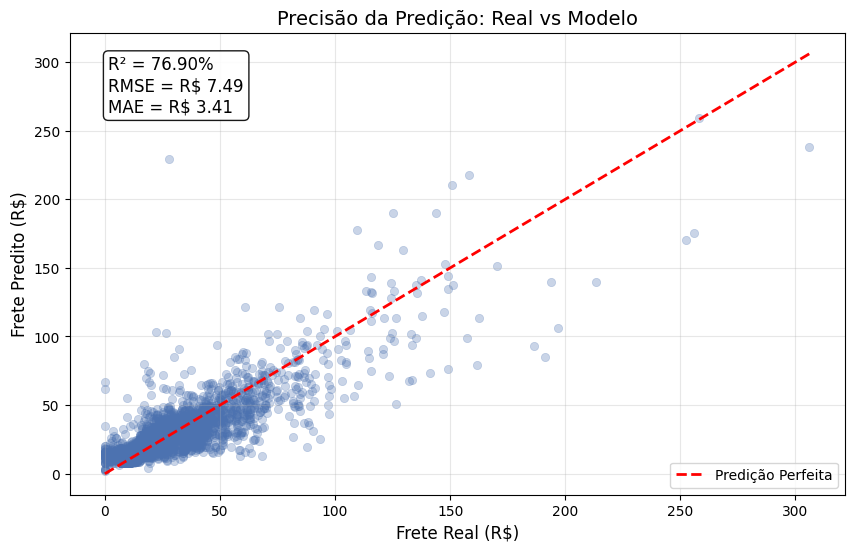

In [10]:
residuals = y_test - y_pred

df_analise = X_test.copy()
df_analise['Real'] = y_test
df_analise['Predito'] = y_pred
df_analise['Erro'] = residuals
df_analise['Erro_Absoluto'] = residuals.abs()

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Real', y='Predito', data=df_analise, alpha=0.3, color='#4c72b0', edgecolor=None)

max_val = max(df_analise['Real'].max(), df_analise['Predito'].max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Predição Perfeita')

text_str = f'R² = {r2_test:.2%}\nRMSE = R$ {rmse_test:.2f}\nMAE = R$ {mae_test:.2f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.title("Precisão da Predição: Real vs Modelo", fontsize=14)
plt.xlabel("Frete Real (R$)", fontsize=12)
plt.ylabel("Frete Predito (R$)", fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.show()

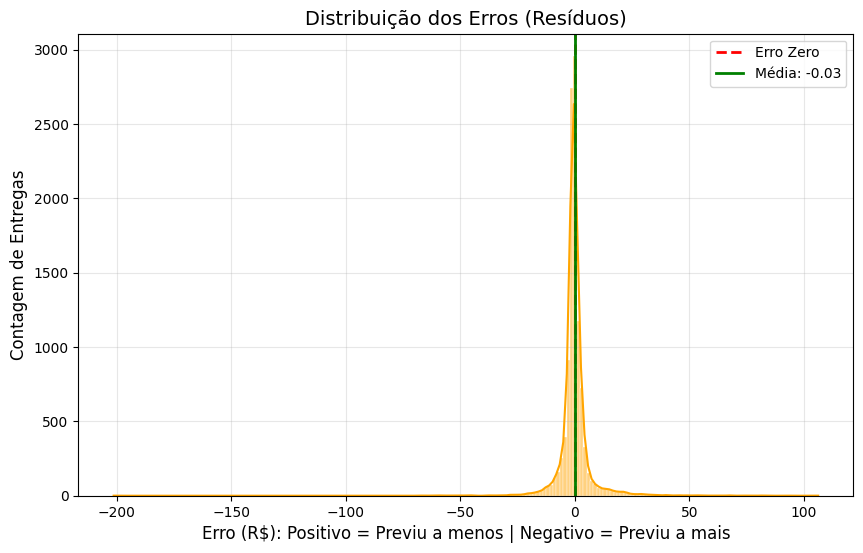

In [11]:
plt.figure(figsize=(10, 6))

sns.histplot(residuals, kde=True, color='orange', edgecolor='white')

plt.axvline(0, color='red', linestyle='--', lw=2, label='Erro Zero')
mean_resid = np.mean(residuals)
plt.axvline(mean_resid, color='green', linestyle='-', lw=2, label=f'Média: {mean_resid:.2f}')

plt.title("Distribuição dos Erros (Resíduos)", fontsize=14)
plt.xlabel("Erro (R$): Positivo = Previu a menos | Negativo = Previu a mais", fontsize=12)
plt.ylabel("Contagem de Entregas", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

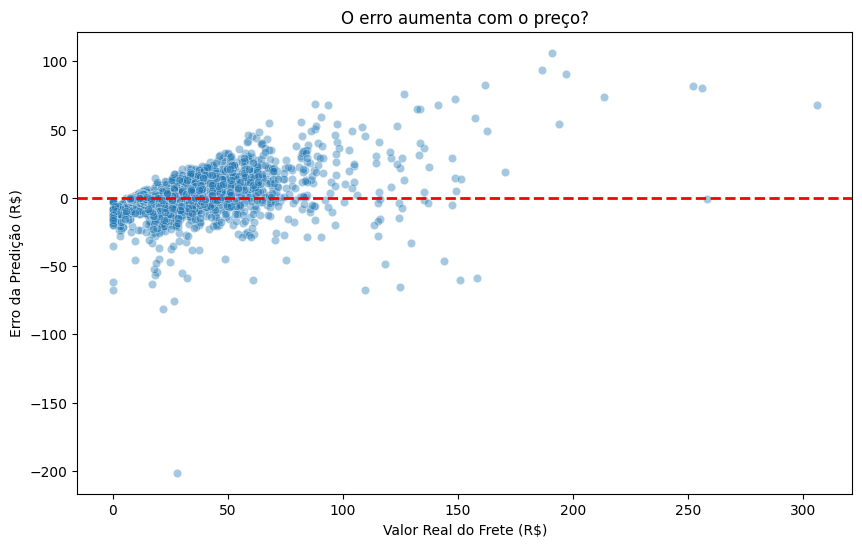

In [12]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='Real', y='Erro', data=df_analise, alpha=0.4)

plt.axhline(0, color='r', linestyle='--', linewidth=2)

plt.title("O erro aumenta com o preço?")
plt.xlabel("Valor Real do Frete (R$)")
plt.ylabel("Erro da Predição (R$)")
plt.show()

## Explicabilidade

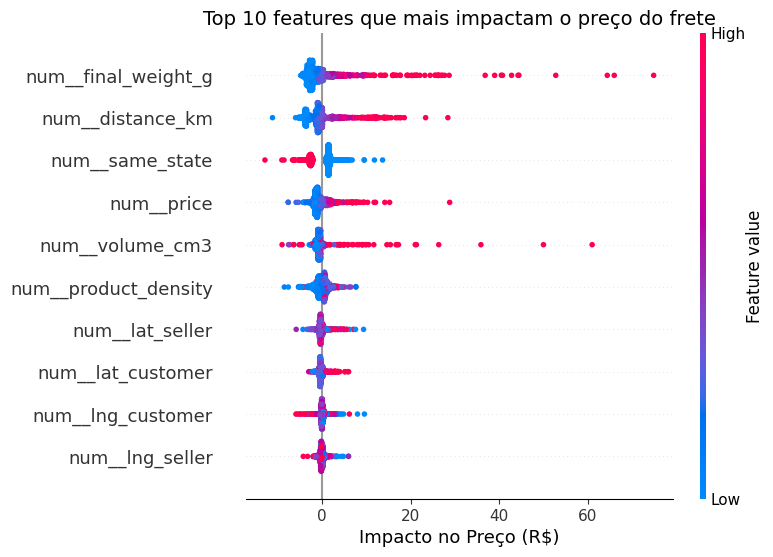

In [13]:
preprocessor = best_model.named_steps['preprocessor']
regressor = best_model.named_steps['model']

X_sample = X_test.sample(1000, random_state=42)
X_transformed = preprocessor.transform(X_sample)

feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_transformed)

plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values, 
    X_transformed, 
    feature_names=feature_names, 
    max_display=10, 
    show=False
)

plt.title("Top 10 features que mais impactam o preço do frete", fontsize=14)
plt.xlabel("Impacto no Preço (R$)")
plt.show()

## Exportação do melhor modelo

In [14]:
joblib.dump(best_model, MODEL_PATH / "freight_prediction_model.pkl")

['..\\..\\..\\models\\T3\\regressao\\freight_prediction_model.pkl']